## Implementing LeNet-5 in Tensorflow



Import libraries

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops
from cnn_utils import *

%matplotlib inline
np.random.seed(1)

In [2]:
# load the dataset
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


(1080, 64, 64, 3)

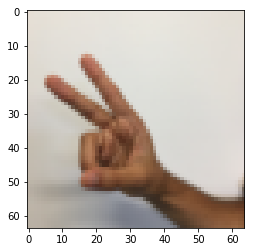

In [3]:
# Example of a picture
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))
X_train_orig.shape

In [4]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}
# create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder("float", [None, n_H0, n_W0, n_C0], name='X')
    Y = tf.placeholder("float", [None, n_y], name='Y')
    ### END CODE HERE ###
    
    return X, Y
# initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [5, 5, 3, 6], initializer=tf.contrib.layers.xavier_initializer(seed=0) )
    W2 = tf.get_variable("W2", [5, 5, 6, 16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 6)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    ### END CODE HERE ###
    
    return cost

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [12]:
def forward_propagation(X, parameters):
    '''Implement the forward propagation to build the following model:
    Layer 1:
    CONV2D -> RELU -> MAXPOOL ->
    Layer 2:
    CONV2D -> RELU -> MAXPOOL -> 
    
    FLATTEN -> 
    Layer 3:
    FULLYCONNECTED ->
    Layer 4:
    FULLYCONENCTED ->
    Layer 5:
    Output
    '''
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # Layer 1:
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='VALID')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2:
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='VALID')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    
    # Layer 3:
    Z3 = tf.contrib.layers.fully_connected(P2, 120, activation_fn=tf.nn.sigmoid)
    
    # Layer 4:
    Z4 = tf.contrib.layers.fully_connected(Z3, 84, activation_fn=tf.nn.sigmoid)
    
    # Layer 5:
    Z5 = tf.contrib.layers.fully_connected(Z4, 6, activation_fn=None)
    
    return Z5
    
    
    

In [15]:
def LeNet5Model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = (X_train.shape)
    #n_C0 = 1
    n_y = Y_train.shape[1]                            
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z5 = forward_propagation(X, parameters)
    cost = compute_cost(Z5, Y)
    # Back propagation
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z5, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters
    

    
    

Cost after epoch 0: 1.975694
Cost after epoch 5: 1.913049
Cost after epoch 10: 1.911086
Cost after epoch 15: 1.912537
Cost after epoch 20: 1.910044
Cost after epoch 25: 1.910661
Cost after epoch 30: 1.908127
Cost after epoch 35: 1.912726
Cost after epoch 40: 1.908176
Cost after epoch 45: 1.907667
Cost after epoch 50: 1.905900
Cost after epoch 55: 1.906075
Cost after epoch 60: 1.908260
Cost after epoch 65: 1.911350
Cost after epoch 70: 1.914631
Cost after epoch 75: 1.911592
Cost after epoch 80: 1.907803
Cost after epoch 85: 1.907299
Cost after epoch 90: 1.910674
Cost after epoch 95: 1.907118


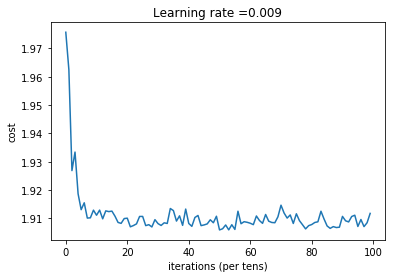

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.16666667
Test Accuracy: 0.16666667


In [17]:
_, _, parameters = LeNet5Model(X_train, Y_train, X_test, Y_test)